## The calculations

Take an image. Draw a circle on it, and take points at regular intervals around that circle.

For every pairing of those points, calculate the average pixel darkness along the line between them.

Divide all the average darknesses into 20 (?) buckets across the range of darknesses, 
so each pair of points is assigned to a bucket.


## The art

For each bucket, use a different darkness of pencil.

Draw the circle and mark out the points around it.

For each pair of points, draw the line between them in the pencil corresponding to the assigned bucket.

In [1]:
## Source image

# Image from a remote URL
import urllib.request
#IMAGE_URL = 'https://placekitten.com/g/600/600'
#IMAGE_URL = 'https://madamsabi.files.wordpress.com/2014/11/wpid-sillitoe-black-white.gif'
#IMAGE_URL = 'https://img00.deviantart.net/fae3/i/f/d/4/black_white.jpg'
#IMAGE_FILE = urllib.request.urlopen(IMAGE_URL)

# Or from a local file
IMAGE_FILE = 'panda-8.jpg'


# Interval of points around the circle
ANGLE_INTERVAL = 2 # degrees

# Circle radius as proportion of largest square that will fit in image
RADIUS_MULTIPLIER = 0.45

# Min/max pixel values (these shouldn't need to change)
LIGHTEST_PIXEL = 255
DARKEST_PIXEL = 0


# Debug output, to show how things are calculated
DEBUG = True


In [2]:
import sys
from collections import namedtuple

from PIL import Image, ImageDraw, ImageFont
from IPython.display import display

img = Image.open(IMAGE_FILE, 'r')

# lets us import utils module
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Open the image
original = img.copy()
draw = ImageDraw.Draw(img)

Point = namedtuple('Point', ['coords', 'angle'])

# A couple of drawing utilities...   
def draw_point_at(p, color='blue'):
    """Draw a point at p, where p is an (x, y) pair of coords"""
    draw.point(p, color)
    
def draw_line_between(p1, p2, color='green'):
    """line between two points, where each is an (x, y) pair of coords"""
    draw.line((*p1, *p2), color, width=1)
    
#display(img)

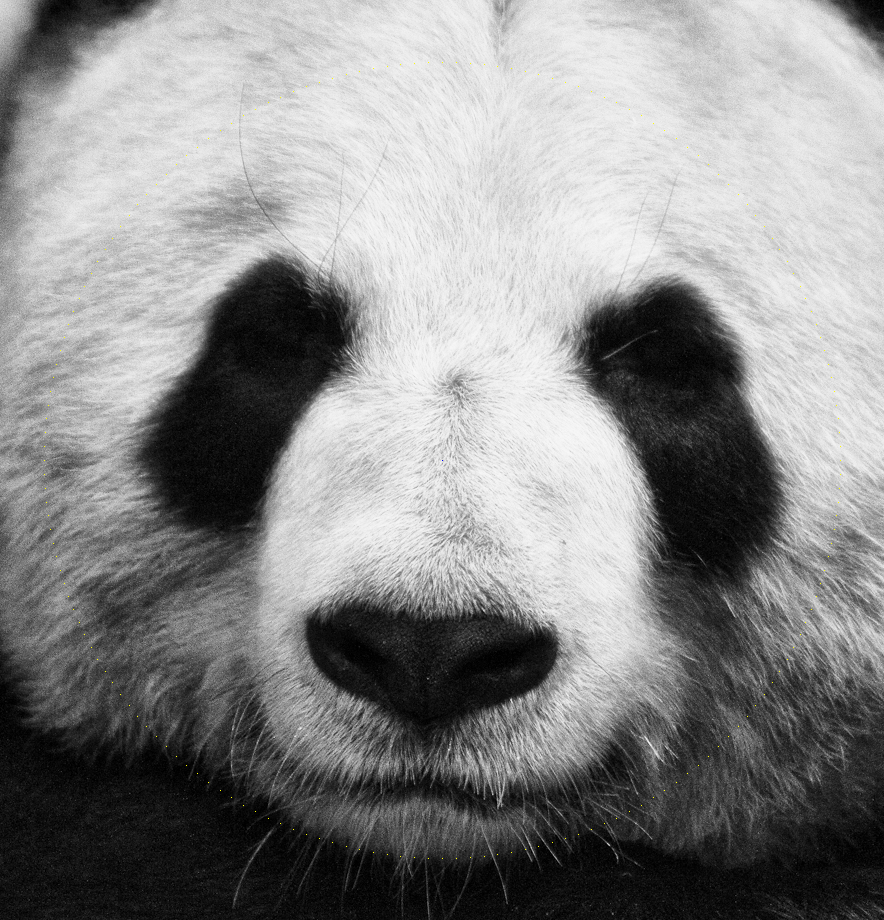

In [3]:
# Generate the points at angle intervals around a circle

from math import sin, cos, degrees, radians

cx = img.width // 2
cy = img.height // 2
r = min(img.width, img.height) * RADIUS_MULTIPLIER

# All the angles around the circle (in radians)
angles = range(0, 360, ANGLE_INTERVAL)

# Coordinates for point on circle at each angle
circle_coords = [
    Point(coords=(cx + round(r*cos(radians(a))), cy + round(r*sin(radians(a)))), angle=a)
    for a in angles
]

if DEBUG:
    # Draw all those points
    draw_point_at((cx, cy))
    for p in circle_coords:
        draw_point_at(p.coords, 'yellow') 
    display(img)

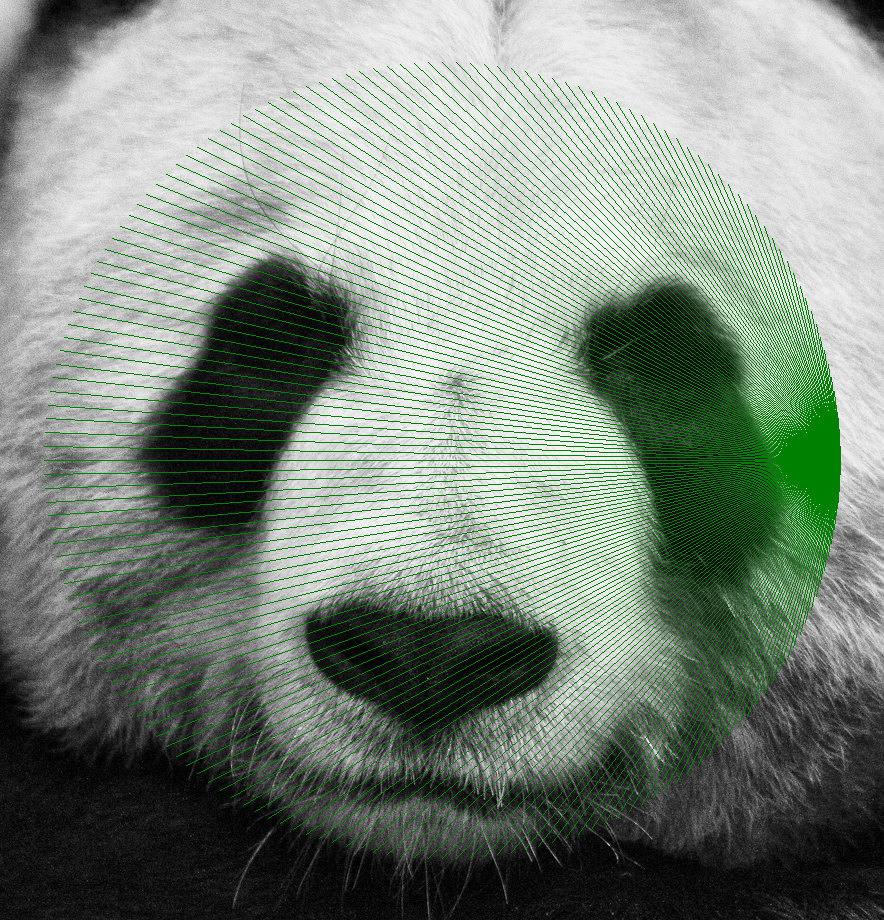

In [4]:
# Generate sets of lines from all the circle coordinates
from itertools import combinations, product

def pairs_of_points():
    """generate all pairs of points (including point with itself)"""
    yield from combinations(circle_coords, r=2)
    
def pairs_for_point(point):
    """a point paired with each other point (including itself)"""
    yield from product([point], circle_coords)
    
if DEBUG:
    # Draw all connecting lines for just one of the points\
    for p1, p2 in pairs_for_point(circle_coords[0]):
        draw_line_between(p1.coords, p2.coords)
    display(img)

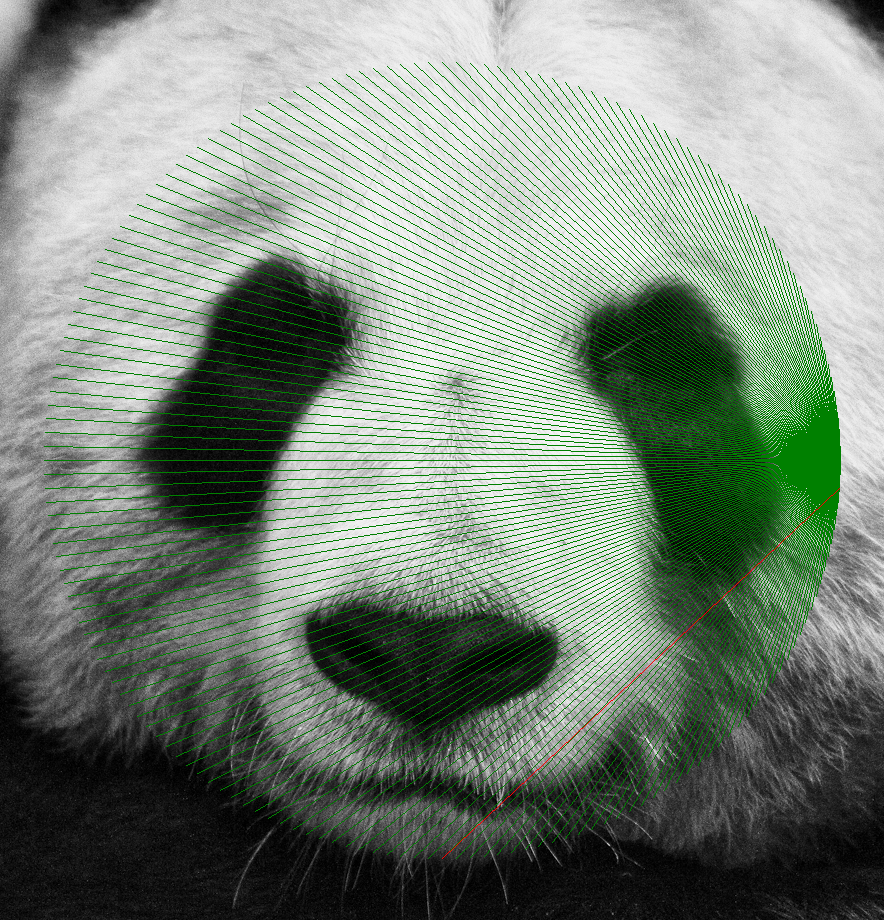

In [5]:
# Work out which pixels lie on a line
from utils import get_line

if DEBUG:
    # Draw our very own line built up from calculated pixels
    p1 = circle_coords[2]
    p2 = circle_coords[len(circle_coords)//4]
    for x, y in get_line(p1.coords, p2.coords):
        draw_point_at((x, y), 'red')
    display(img)

In [6]:
from statistics import mean

def pixel_darkness(r, g, b):
    """
    Darkness value of the given rgb values
    
    (This is subtracted from 255 b/c higher rgb values are lighter)
    """
    return 255 - ((r + g + b) / 3)

def average_line_darkness(p1, p2):
    """
    Average darkness level of all pixels on a line between p1 and p2
    """
    return mean(
        pixel_darkness(*original.getpixel((x, y)))
        for (x, y) in get_line(p1.coords, p2.coords)
    )


darkest = DARKEST_PIXEL
lightest = LIGHTEST_PIXEL
values = []
for (p1, p2) in pairs_of_points():
    value = round(average_line_darkness(p1, p2), 2)
    values.append((p1, p2, value))
    darkest = max(value, darkest)
    lightest = min(value, lightest)

print('%d values' % len(values))

output_darkness_range = darkest - lightest
if DEBUG:
    print(darkest, lightest)


16110 values
247.92 19.87


In [11]:
# Pencil darkness range - 255 is darkest possible, 0 is lightest possible
DARKEST_PENCIL = 80
LIGHTEST_PENCIL = 0

# How many pencils are we using? (9H-9B is 20 pencils)
NUMBER_OF_PENCILS = 20


pencil_darkness_range = DARKEST_PENCIL - LIGHTEST_PENCIL

bucket_darknesses = [
    int(LIGHTEST_PENCIL + pencil_darkness_range * (bucket / NUMBER_OF_PENCILS))
    for bucket in range(0, NUMBER_OF_PENCILS)
]
fnt = ImageFont.truetype('Pillow/Tests/fonts/FreeMono.ttf', 10)

if DEBUG:
    pencil_img = Image.new('RGBA', (20*NUMBER_OF_PENCILS, 21), 'white')
    for i, darkness in enumerate(bucket_darknesses):
        pencil_draw = ImageDraw.Draw(pencil_img)
        pencil_draw.rectangle((20*i, 0, 20*(i+1), 20), outline=(255, 255, 255), fill=(0, 0, 0, darkness))
        pencil_draw.text((20*i+5, 7), str(i), font=fnt, fill='black' if darkness < 180 else 'lightblue')
        
    # Illustrate the pencil darknesses we are using
    print(bucket_darknesses)        
    display(pencil_img)

[0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76]


used 16110 lines


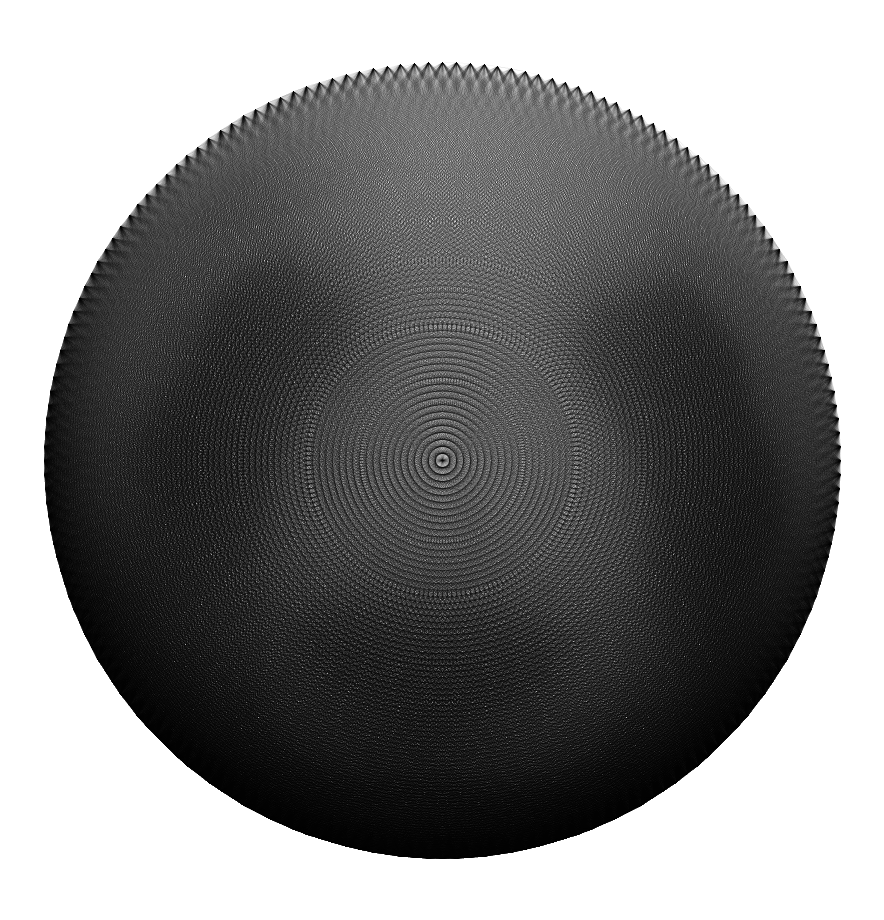

In [12]:
def get_bucket(val):
    return min(int(((val - lightest) / output_darkness_range) * NUMBER_OF_PENCILS), NUMBER_OF_PENCILS-1)


art = Image.new('RGBA', (img.width, img.height), 'white')

for p1, p2, value in values:
    tmp_img = Image.new('RGBA', (img.width, img.height)) # Use RGBA
    draw2 = ImageDraw.Draw(tmp_img)
    
    bucket = get_bucket(value)
    # print(p1.angle, p2.angle, bucket)
    
    line_darkness = bucket_darknesses[bucket]
    draw2.line(((p1.coords[0], p1.coords[1]), (p2.coords[0], p2.coords[1])), fill=(0, 0, 0, line_darkness))

    art = Image.alpha_composite(art, tmp_img)
  
# Output the final image...
print('used %d lines' % len(values))
display(art)